In [ ]:
%pip install pyogmaneo scipy matplotlib numpy datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 1.7 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.3/35.3 MB 17.9 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
from datasets import load_dataset
import numpy as np
import pyaogmaneo as neo
import scipy.ndimage
from copy import copy

# Set number of threads for parallel processing
neo.set_num_threads(8)

# Load the Fashion MNIST dataset
dataset = load_dataset("zalando-datasets/fashion_mnist")

# Print dataset info
print("Training samples:", dataset["train"].num_rows)
print("Test samples:", dataset["test"].num_rows)

# Define the class names for better visualization
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


Training samples: 60000
Test samples: 10000


In [13]:
# Import additional libraries for visualization
import matplotlib.pyplot as plt
import os

# Define network dimensions
img_size = (28, 28, 1)  # Original image size
hidden_size = (16, 16, 64)  # Hidden layer size
input_res = 4  # Number of quantization levels for input

# Check if saved model exists
model_path = "fashion_mnist_model.ohr"
if os.path.exists(model_path):
    print(f"Loading existing model from {model_path}")
    h = neo.Hierarchy(file_name=model_path)

else:
    print("Creating new model...")
    # Create the hierarchy
    h = neo.Hierarchy([
        # Image input layer
        neo.IODesc((img_size[0], img_size[1], input_res),
                  io_type=neo.none,  # Regular input (not predicted)
                  up_radius=8),  # Large radius to capture spatial patterns
        
        # Label prediction layer
        neo.IODesc((1, 1, 10),  # 10 classes
                  io_type=neo.prediction,  # This layer makes predictions
                  num_dendrites_per_cell=64,  # Many dendrites for robust prediction
                  up_radius=0,  # No upward connections needed
                  down_radius=8)  # Large radius to capture hidden patterns
        ],
        # Hidden layer configuration
        1 * [ neo.LayerDesc(hidden_size,
                          recurrent_radius=-1) ]  # No recurrent connections
    )
    
    # Set importance of image layer to 0 (we don't predict images)
    h.params.ios[1].importance = 0.0


Loading existing model from fashion_mnist_model.ohr


In [6]:
label_prev = 0
average_correct = 0.0
num_epochs = 10
iters_per_epoch = 50000
total_iters = num_epochs * iters_per_epoch

for it in range(total_iters):
    # Get random training sample
    index = np.random.randint(0, dataset["train"].num_rows)
    img = np.array(dataset["train"][index]["image"], dtype=np.float32) / 255.0
    label = int(dataset["train"][index]["label"])
    
    # Preprocess image - quantize to input_res levels
    input_cis = (np.minimum(1.0, np.maximum(0.0, img)) * (input_res - 1) + 0.5).astype(np.int32)
    
    # Step the hierarchy (learn = True)
    h.step([input_cis.ravel().tolist(), [label_prev]], True)
    
    # Get prediction
    prediction = h.get_prediction_cis(1)[0]
    
    # Update for next iteration
    label_prev = label
    
    # Update metrics
    correct = float(prediction == label)
    average_correct = 0.999 * average_correct + 0.001 * correct
    
    # Print progress every 100 iterations
    if it % 100 == 99:
        epoch = (it + 1) // iters_per_epoch
        epoch_iter = (it + 1) % iters_per_epoch
        print(f"Epoch {epoch}/{num_epochs}, Iteration {epoch_iter}/{iters_per_epoch}")
        print(f"Moving Average Accuracy: {average_correct:.3f}")
        print(f"Current Sample: {class_names[label]} (Predicted: {class_names[prediction]})")
        print("---")


Epoch 0/10, Iteration 100/50000
Moving Average Accuracy: 0.093
Current Sample: Pullover (Predicted: Pullover)
---
Epoch 0/10, Iteration 200/50000
Moving Average Accuracy: 0.180
Current Sample: Pullover (Predicted: Pullover)
---
Epoch 0/10, Iteration 300/50000
Moving Average Accuracy: 0.257
Current Sample: Trouser (Predicted: Trouser)
---
Epoch 0/10, Iteration 400/50000
Moving Average Accuracy: 0.328
Current Sample: Sandal (Predicted: Sandal)
---
Epoch 0/10, Iteration 500/50000
Moving Average Accuracy: 0.389
Current Sample: Shirt (Predicted: Shirt)
---
Epoch 0/10, Iteration 600/50000
Moving Average Accuracy: 0.443
Current Sample: T-shirt/top (Predicted: T-shirt/top)
---
Epoch 0/10, Iteration 700/50000
Moving Average Accuracy: 0.496
Current Sample: Shirt (Predicted: Shirt)
---
Epoch 0/10, Iteration 800/50000
Moving Average Accuracy: 0.543
Current Sample: Sneaker (Predicted: Sneaker)
---
Epoch 0/10, Iteration 900/50000
Moving Average Accuracy: 0.585
Current Sample: Shirt (Predicted: Shirt

KeyboardInterrupt: 

In [7]:
print("================= TESTING =================")

# Initialize metrics
test_correct = 0
test_amount = dataset["test"].num_rows
class_correct = np.zeros(10)
class_total = np.zeros(10)

# Test loop
for it in range(test_amount):
    # Get test sample
    img = np.array(dataset["test"][it]["image"], dtype=np.float32) / 255.0
    label = int(dataset["test"][it]["label"])
    
    # Preprocess image
    input_cis = (np.minimum(1.0, np.maximum(0.0, img)) * (input_res - 1) + 0.5).astype(np.int32)
    
    # Step the hierarchy (learn = False)
    h.step([input_cis.ravel().tolist(), [0]], False)
    
    # Get prediction
    prediction = h.get_prediction_cis(1)[0]
    
    # Update metrics
    correct = prediction == label
    test_correct += correct
    class_correct[label] += correct
    class_total[label] += 1
    
    # Print progress
    if it % 1000 == 999:
        print(f"Processed {it+1}/{test_amount} test samples")

# Calculate final metrics
overall_accuracy = test_correct / test_amount
class_accuracies = class_correct / class_total

# Print results
print("\nTest Results:")
print(f"Overall Accuracy: {overall_accuracy:.3f}")
print("\nPer-class Accuracies:")
for i in range(10):
    print(f"{class_names[i]}: {class_accuracies[i]:.3f}")


================= TESTING =================
Processed 1000/10000 test samples
Processed 2000/10000 test samples
Processed 3000/10000 test samples
Processed 4000/10000 test samples
Processed 5000/10000 test samples
Processed 6000/10000 test samples
Processed 7000/10000 test samples
Processed 8000/10000 test samples
Processed 9000/10000 test samples
Processed 10000/10000 test samples

Test Results:
Overall Accuracy: 0.860

Per-class Accuracies:
T-shirt/top: 0.825
Trouser: 0.959
Pullover: 0.783
Dress: 0.867
Coat: 0.768
Sandal: 0.940
Shirt: 0.589
Sneaker: 0.958
Bag: 0.961
Ankle boot: 0.947


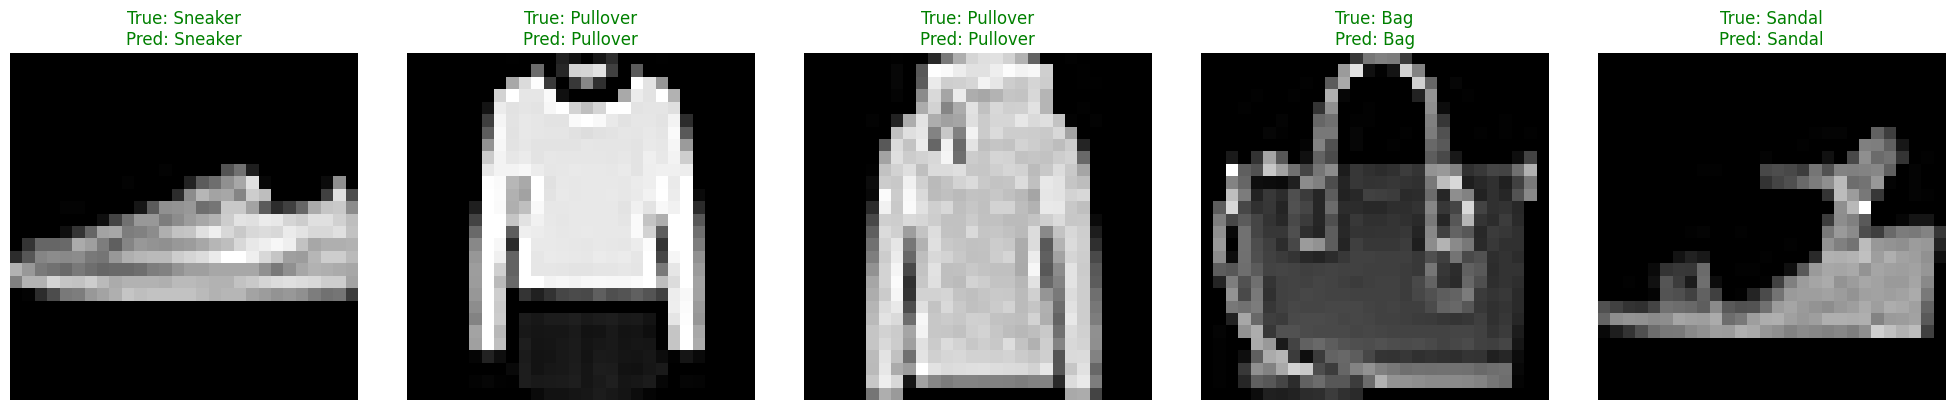

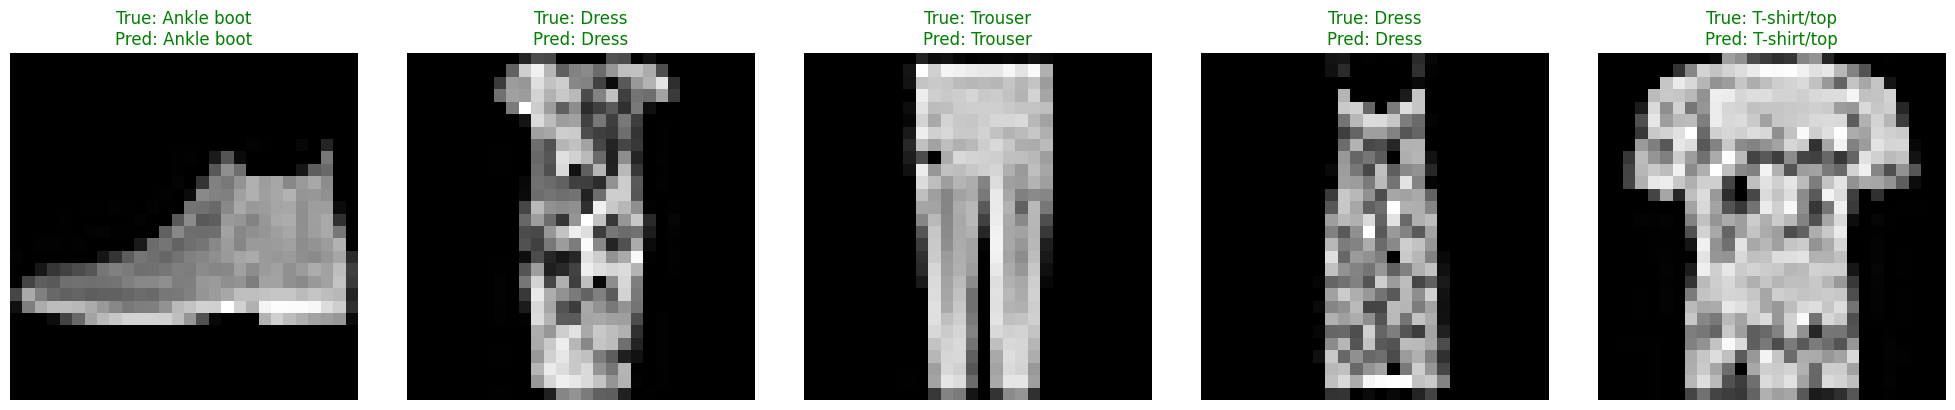

In [15]:
def predict_and_display(indices):
    # Set up the plot
    num_images = len(indices)
    fig, axes = plt.subplots(1, num_images, figsize=(4*num_images, 4))
    if num_images == 1:
        axes = [axes]
    
    for idx, ax in zip(indices, axes):
        # Convert numpy int to Python int
        idx = int(idx)
        
        # Get the image and label
        img = np.array(dataset["test"][idx]["image"])
        label = int(dataset["test"][idx]["label"])
        
        # Preprocess for prediction
        img_normalized = img.astype(np.float32) / 255.0
        input_cis = (np.minimum(1.0, np.maximum(0.0, img_normalized)) * (input_res - 1) + 0.5).astype(np.int32)
        
        # Get prediction
        h.step([input_cis.ravel().tolist(), [0]], False)
        prediction = h.get_prediction_cis(1)[0]
        
        # Display image
        ax.imshow(img, cmap='gray')
        ax.axis('off')
        
        # Add title with true label and prediction
        color = 'green' if prediction == label else 'red'
        ax.set_title(f'True: {class_names[label]}\nPred: {class_names[prediction]}', 
                    color=color)
    
    plt.tight_layout()
    plt.show()

# Test on 5 random images
random_indices = np.random.randint(0, dataset["test"].num_rows, size=5).tolist()  # Convert to Python list
predict_and_display(random_indices)

# Test on some specific examples (optional)
# You can modify these indices to look at specific examples
specific_indices = [0, 100, 200, 300, 400]  # Already Python integers
predict_and_display(specific_indices)


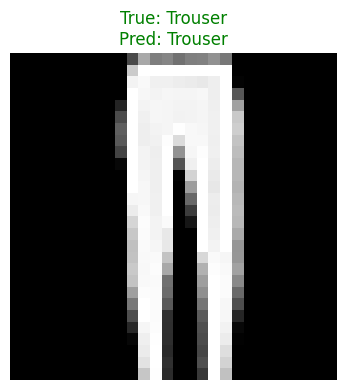

In [17]:
# Change this index to test different images
test_index = 41  # You can modify this number (0 to 9999)
predict_and_display([int(test_index)])  # Convert to Python int


In [8]:
# Save the trained hierarchy
h.save_to_file("fashion_mnist_model.ohr")
print("Model saved to fashion_mnist_model.ohr")


Model saved to fashion_mnist_model.ohr
